In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import pandas as pd
%matplotlib inline

import sys
sys.path.insert(1, '../library')

sys.path.insert(2, '../python_library')
import pyram as pr

from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy
from itertools import combinations
from itertools import product

from scipy.spatial import distance

In [19]:
pr.charge_lib('full')

Charging pure spectra library, needs around a minute ....
Done. Good work!


In [20]:
lib_names = list(pr.lib().keys())

In [30]:
def RRUFF2DF():
    name = ['']*len(lib_names)
    RRUFF_ID = ['']*len(lib_names)
    spectra_type = ['']*len(lib_names)
    wave_length = ['']*len(lib_names)
    spectra = [0]*len(lib_names)

    for i in range(len(lib_names)):
        name_t = ''
        RRUFF_ID_t = ''
        spectra_type_t = ''
        wave_length_t = ''
        step = 0

        for j in lib_names[i]:
            if step == 0 and j != '_':
                name_t += j
            elif step == 2 and j != '_':
                RRUFF_ID_t += j
            elif step == 4 and j != '_':
                spectra_type_t += j
            elif step == 6 and j != '_':
                wave_length_t += j
            else:
                step+=1
            
        name[i] = name_t
        RRUFF_ID[i] = RRUFF_ID_t
        spectra_type[i] = spectra_type_t
        wave_length[i] = wave_length_t
        spectra[i] = pr.lib(lib_names[i])

    global RRUFF_lib
    RRUFF_lib = pd.DataFrame({'name':name, 'RRUFF_ID':RRUFF_ID, 'spectra_type':spectra_type, 'laser':wave_length, 'S':spectra})
   
    return RRUFF_lib

RRUFF_lib = RRUFF2DF()

RRUFF_lib = RRUFF_lib[RRUFF_lib.laser == '532']
RRUFF_lib


,name,RRUFF_ID,spectra_type,laser,S
0,Abelsonite,R070007,Raman,532,"[[154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 16..."
4,Actinolite,R040063,Raman,532,"[[119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 12..."
7,Actinolite,R040064,Raman,532,"[[119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 12..."
10,Actinolite,R050025,Raman,532,"[[144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 15..."
13,Actinolite,R050336,Raman,532,"[[141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 14..."
...,...,...,...,...,...
5115,Zunyite,R050263,Raman,532,"[[139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 14..."
5117,Zunyite,R050553,Raman,532,"[[147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 15..."
5121,Zwieselite,R050279,Raman,532,"[[136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 14..."
5123,Zykaite,R070477,Raman,532,"[[148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 15..."


In [33]:
all_names =np.unique(RRUFF_lib.name, return_counts=True)

SUB = []
for i in range(len(all_names[0])):
    if all_names[1][i] > 5:
        SUB.append(all_names[0][i])

elements = SUB

#elements = ['Quartz', 'Albite', 'Calcite', 'Dolomite', 'Gypsum', 'Magnesite', 'Talc', 'Forsterite']#,'Chrysotile']

#elements = ['Albite',  'Labradorite', 'Orthoclase']

#elements = ['Tremolite', 'Actinolite']

#elements = ['Clinochlore', 'Vermiculite','Phlogopite']


cond = ''
for i in elements[:-1]:
    cond += 'name == "'+i+'" or '
cond += 'name == "'+elements[-1]+'"'

data = RRUFF_lib.query(cond)
#data = data[data.laser == '532']

def get_confusion_similarity(data):
    
    data.reset_index(inplace=True, drop=True)

    names = data.name
    match = np.zeros((len(names),len(names)))
    
    for i in range(len(names)):
        for j in range(len(names)):
            match[i,j] = pr.cos_sim_w_shift(data.iloc[i].S, data.iloc[j].S, shift=3)

    return match

M = get_confusion_similarity(data)

<AxesSubplot:>

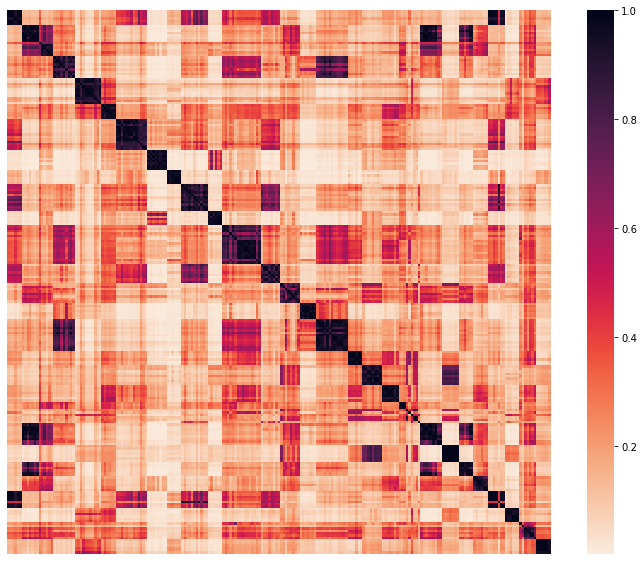

In [34]:
plt.figure(figsize=(13,10))
sns.heatmap(M, cmap = sns.color_palette("rocket_r", as_cmap=True),annot=False, square=True, xticklabels=False, yticklabels=False)

In [379]:
names = data.name
ID = data.RRUFF_ID
N = len(names)
ind = np.arange(N)

unique = np.unique(data.name, return_counts=True)
L = len(unique[0])

train = []
test = []

pos=0

for i in range(L):

    train += list(ind[pos:pos+unique[1][i]//2])
    test += list(ind[pos+unique[1][i]//2:pos+unique[1][i]])

    pos+=unique[1][i]

out = []
check = []
for i in test:
    for j in train:
        if M[i,:][j] == np.max(M[i,:][train]):
            out.append([names[i],names[j]])
            check.append([ID[i],ID[j]])

out = pd.DataFrame(np.array(out),columns=['True label','Predicted label'])

for i in check:
    if i[0] == i[1]:
        print(i)
print('train = ',train)
print('test = ',test)
print(list(ID[train]))
print(list(ID[test]))


train =  [0, 1, 2, 6, 7, 8, 13, 14, 15, 19, 20, 21, 22, 28, 29, 30, 31, 32, 39, 40, 41, 45, 46, 47, 48, 49, 50, 58, 59, 60, 61, 66, 67, 68, 72, 73, 74, 75, 76, 83, 84, 85, 89, 90, 91, 95, 96, 97, 98, 99, 105, 106, 107, 108, 113, 114, 115, 116, 121, 122, 123, 128, 129, 130, 131, 132, 133, 141, 142, 143, 147, 148, 149, 150, 155, 156, 157, 162, 163, 164, 165, 171, 172, 173, 174, 180, 181, 182, 187, 188, 189, 193, 194, 195, 199, 200, 201, 206, 207, 208, 212, 213, 214, 219, 220, 221]
test =  [3, 4, 5, 9, 10, 11, 12, 16, 17, 18, 23, 24, 25, 26, 27, 33, 34, 35, 36, 37, 38, 42, 43, 44, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 69, 70, 71, 77, 78, 79, 80, 81, 82, 86, 87, 88, 92, 93, 94, 100, 101, 102, 103, 104, 109, 110, 111, 112, 117, 118, 119, 120, 124, 125, 126, 127, 134, 135, 136, 137, 138, 139, 140, 144, 145, 146, 151, 152, 153, 154, 158, 159, 160, 161, 166, 167, 168, 169, 170, 175, 176, 177, 178, 179, 183, 184, 185, 186, 190, 191, 192, 196, 197, 198, 202, 203, 204, 205, 209, 210, 211, 2

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

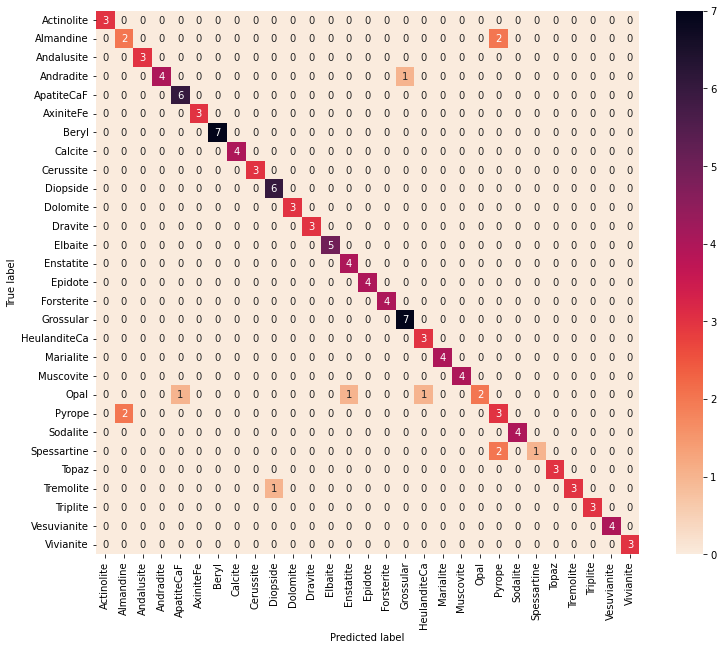

In [380]:
out = pd.DataFrame(out,columns=['True label','Predicted label'])

plt.figure(figsize=(13,10))
sns.heatmap(pd.crosstab(out['True label'], out['Predicted label']), cmap = sns.color_palette("rocket_r", as_cmap=True),annot=True, square=True)

In [383]:
len(data.name)

225

In [385]:
(len(test)-12)/len(test)


0.8991596638655462